# King County Housing EDA

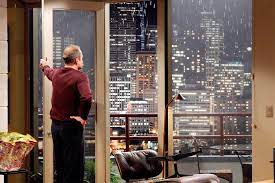

This Notebook is about doing an explorative Data Analysis on a Dataset of Houses sold in the area of King County, Washington, US

It will guide you through the individual steps and explains the thoughts behind it.

So, lets begin!

## 0. Importing modules

First, importing needed modules and setting some parameters for visualizations

In [173]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import geopandas as gpd
import re
from scipy.spatial.distance import cdist
import calendar
import matplotlib.patches as mpatches


plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black", 'font.size':20})
plt.rcParams["figure.facecolor"]= "w"
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [8.0, 5.0]
SMALL_SIZE = 14
mpl.rc('font', size=SMALL_SIZE)
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Data

### 1.1 Importing Data

This EDA is using three datasets. 

The main Dataset is the King County House prices dataset and contains 21597 of data records. 

Each record containing 21 fields. 
Let's read the file and have a look at the head.


In [77]:
# King County House Dataset
df = pd.read_csv('data/King_County_House_prices_dataset.csv')

#Show first 3 records
df.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.000,3,1.000,1180,5650,1.000,NaN,0.000,...,7,1180,0.0,1955,0.000,98178,47.511,-122.257,1340,5650
1,6414100192,12/9/2014,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,...,7,2170,400.0,1951,1991.000,98125,47.721,-122.319,1690,7639
2,5631500400,2/25/2015,180000.000,2,1.000,770,10000,1.000,0.000,0.000,...,6,770,0.0,1933,NaN,98028,47.738,-122.233,2720,8062


Next, we will import a shape file that gives us information about the zip code area borders

This file will be important for visualize our geographical results.

In [76]:
#read the shape file of the zip code areas of king county
zip_shape_df = gpd.read_file('data/Zipcodes/Zipcodes_for_King_County_and_Surrounding_Area_(Shorelines)___zipcode_shore_area.shp') 
zip_shape_df.head(3)


,OBJECTID,ZIP,ZIPCODE,COUNTY,ZIP_TYPE,COUNTY_NAM,PREFERRED_,Shape_Leng,Shape_Area,geometry
0,1,98001,98001,033,Standard,King County,AUBURN,148134.771,526121353.974,"POLYGON ((-122.22992 47.35377, -122.22993 47.3..."
1,2,98002,98002,033,Standard,King County,AUBURN,105168.477,204445228.298,"POLYGON ((-122.22921 47.35375, -122.22915 47.3..."
2,3,98003,98003,033,Standard,King County,FEDERAL WAY,121645.070,316981231.585,"POLYGON ((-122.30940 47.35795, -122.30940 47.3..."


In [ ]:
#read csv containing population information about the zip code areas in king county
pop_dens = pd.read_csv('data/us_population_density_by_zip_september2020.csv')

### 1.2 Additional Info about Dataset

Next we will look at our data and get some information about the Dtypes.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

We got 8 float & 11 Integers Dtypes, but also two 'object' Dtypes.

The column 'date' should contain the date in string format. Column 'sqft_basement' should be the area as a float Dtype. We will find out later why this is not the case.


Also there are 3 columns with NaN values. In a later step we will think about what we do with the missing values. 

### 1.3 Descriptive Statistics of Dataset

To better understand the data we will visualize some of the Feature distributions of our data.

Also we are looking at some descriptive statistic values like mean, min, max or median

In [269]:

def format_number(data_value, indx):
    """ 
    Helper function for formatting large Numbers in X/Y-Tick-Labels
    Returns a formatter for 'set_major_formatter'
    """
    if data_value >= 1_000_000:
        formatter = '{:1.1f}M'.format(data_value*0.000_001)
    else:
        formatter = '{:1.0f}K'.format(data_value*0.001)
    return formatter

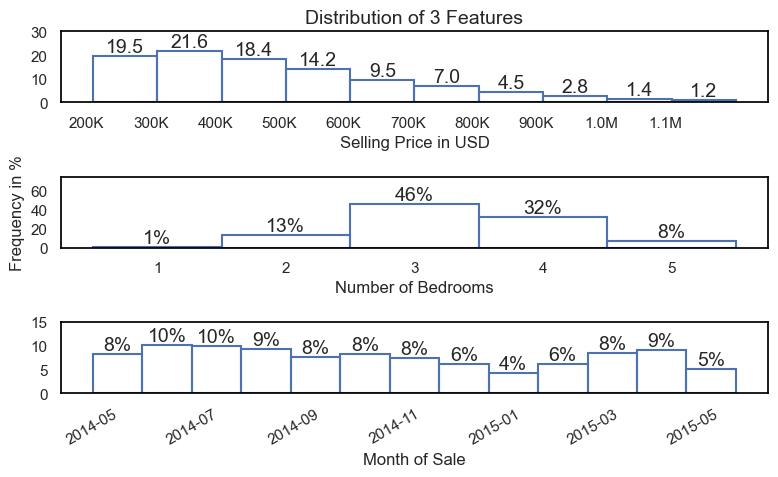

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,19221.000,21534.000,21597.000,21597.000,21597.000,21597.000,17755.000,21597.000,21597.000,21597.000,21597.000,21597.000
mean,4580474287.771,540296.574,3.373,2.116,2080.322,15099.409,1.494,0.008,0.234,3.410,7.658,1788.597,1971.000,83.637,98077.952,47.560,-122.214,1986.620,12758.284
std,2876735715.748,367368.140,0.926,0.769,918.106,41412.637,0.540,0.087,0.766,0.651,1.173,827.760,29.375,399.946,53.513,0.139,0.141,685.230,27274.442
min,1000102.000,78000.000,1.000,0.500,370.000,520.000,1.000,0.000,0.000,1.000,3.000,370.000,1900.000,0.000,98001.000,47.156,-122.519,399.000,651.000
25%,2123049175.000,322000.000,3.000,1.750,1430.000,5040.000,1.000,0.000,0.000,3.000,7.000,1190.000,1951.000,0.000,98033.000,47.471,-122.328,1490.000,5100.000
50%,3904930410.000,450000.000,3.000,2.250,1910.000,7618.000,1.500,0.000,0.000,3.000,7.000,1560.000,1975.000,0.000,98065.000,47.572,-122.231,1840.000,7620.000
75%,7308900490.000,645000.000,4.000,2.500,2550.000,10685.000,2.000,0.000,0.000,4.000,8.000,2210.000,1997.000,0.000,98118.000,47.678,-122.125,2360.000,10083.000
max,9900000190.000,7700000.000,33.000,8.000,13540.000,1651359.000,3.500,1.000,4.000,5.000,13.000,9410.000,2015.000,2015.000,98199.000,47.778,-121.315,6210.000,871200.000


In [283]:
fig, axes = plt.subplots(3,1)
#Number of Houses per price category 
g = sns.histplot(ax=axes[0],data=df,x = 'price',log_scale = (False,False),
    element="bars", stat='percent', fill = False, binwidth = 100e3, binrange=(df.price.quantile(0.05),df.price.quantile(0.95)))
g.set_xticks(np.arange(2e5,12e5,1e5))
g.bar_label(g.containers[0], fmt='%.1f')
g.set_ylim(0,30)
g.set_xlabel('Selling Price in USD')
g.ticklabel_format(useOffset=False, style='plain')
g.xaxis.set_major_formatter(format_number)
g.set_yticks(np.arange(0,35,10))
g.set_ylabel('')
g.set_title('Distribution of 3 Features',fontsize = 14)
#distribution of bedrooms in sold houses. quantile(0.95) because i dont want to show outliers for better visualisation)
g=sns.histplot(ax=axes[1], data=df, x= 'bedrooms', binwidth=1, binrange=(0.5,df.bedrooms.quantile(0.95)), element="bars", stat='percent', fill = False)
g.bar_label(g.containers[0], fmt='%.f%%',label_type='edge')
g.set_ylim(0,75)
g.set_yticks(np.arange(0,80,20))
g.set_xlabel('Number of Bedrooms')
g.set_ylabel('Frequency in %')

# number of houses sold per month 
g = sns.histplot(ax=axes[2], data=df, x = pd.to_datetime(df.date), binwidth=30, element="bars", stat='percent', fill = False) #bins of size 30 days
plt.xticks(rotation=30)
g.bar_label(g.containers[0], fmt='%.f%%')
g.set_ylim(0,15)
g.set_yticks(np.arange(0,20,5))
g.set_xlabel('Month of Sale')
g.set_ylabel('')
plt.tight_layout()
plt.show()

#show some simple descriptive statistics
df.describe()



We can see that the Selling price distribution is skewed. Most of the Houses sold are in a range between 300 and 650 USD. 

Almost 50 % of the sold houses got 3 bedrooms. Also one record got a big outlier with 33 bedrooms. WOW!

Lookng at the Month of Sale Distribution, we can see that less houses were sold in the winter months. Also in the last recorded month there are less houses sold than before. It is possible that we have not all the data available for May 2015.

## 2. Hypotheses

Lets think about three hypthoses we could ask us:

* buying a house in a city is more pricy than buying a house in the country side.
* The King County House grade have a big effect on house prices
* the house prices depend on the season of year


Also we want to help our stakeholder Thomas Hansen to buy a house. Here are some important things about Thomas:
* Thomas is mid-age with a badly paid job at a callcenter
* thomas is marired and has 5 children
* Thomas likes to live in a social environment
* Thomas needs a house for his family so with 5 childrens the least number of bedrooms should be 3 + 1 for him and his wife
* A plus for him could be a house near a school with a good school rating


Thomas wants to buy a house but has little money. He needs help with buying a house. So this three recommendations he needs:
* Best locations for cheap houses, which are social friendly
* Best time of the year to buy a house
* What features does he have to live without in order to find an affordable house?

## 3. Data Cleaning

In [6]:
df.date = pd.to_datetime(df.date)
df.yr_renovated = pd.to_datetime(df.yr_renovated)

In [7]:
# See what other character can be found in the sqft_basement column
df[df.sqft_basement.str.findall('[^0-9.]+').str.len() != 0].sqft_basement.unique()

array(['?'], dtype=object)

We now know that the column is no float object because there are rows with an "?" instead of a number

We can replace the ? with a NaN

In [8]:
df.sqft_basement = df.sqft_basement.replace('?',np.NaN)
df.sqft_basement = pd.to_numeric(df.sqft_basement)
df.sqft_basement.info()



<class 'pandas.core.series.Series'>
RangeIndex: 21597 entries, 0 to 21596
Series name: sqft_basement
Non-Null Count  Dtype  
--------------  -----  
21143 non-null  float64
dtypes: float64(1)
memory usage: 168.9 KB


Let's look for NaN's and what we can do with them

In [9]:
df.columns[df.isna().any()].tolist() #columns with NaNs
df.isna().sum()/df.shape[0]*100

#df.view[df.view != 0]


id               0.000
date             0.000
price            0.000
bedrooms         0.000
bathrooms        0.000
sqft_living      0.000
sqft_lot         0.000
floors           0.000
waterfront      11.002
view             0.292
condition        0.000
grade            0.000
sqft_above       0.000
sqft_basement    2.102
yr_built         0.000
yr_renovated    17.790
zipcode          0.000
lat              0.000
long             0.000
sqft_living15    0.000
sqft_lot15       0.000
dtype: float64

* yr_renovated could be NaN because the house was not renovated yet. We can leave the NaNs but keep them in mind when working with this column.
* sqft_basement: For this column we can calculate the missing numbers by assuming that the basement_space = living_space - above_space
* the small percentage (0.3 %) of missing values of view will not be changed for now
* for waterfront lets have a look at the map and see if one of the houses with missing values is actually near water!!! change this to other approach


As you could see it seems that there are houses right at the water. 

What we will do next is to find out the nearest houses to the houses with waterfront = NaN

Than we will replace the NaN value with the Value of the nearest house.

In [10]:
def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]


df['point'] = [(x, y) for x,y in zip(df['long'], df['lat'])]

df_water_nan = df[df.waterfront.isna()]
df_water_notnan = df[df.waterfront.notna()]



df_water_nan['closest'] = [closest_point(x, list(df_water_notnan['point'])) for x in df_water_nan['point']]
df_water_nan_m = df_water_nan.reset_index().merge(df_water_notnan[['waterfront','point']],how = 'left',left_on = 'closest', right_on='point', suffixes = ('_this', '_nearest')).set_index('index')

df = pd.merge(df,df_water_nan_m[['id','waterfront_nearest']],on='id',how='left')

df.waterfront = df.waterfront.fillna(df.waterfront_nearest)
df.waterfront.isna().sum()
df.drop('waterfront_nearest',axis=1,inplace = True)


### create some year/month/weekday columns from the date column

In [11]:
df['year_sold'] = df.date.dt.year
df['month_sold'] = df.date.dt.month
df['weekday_sold'] = df.date.dt.weekday
df['day_sold'] = df.date.dt.day
df['week_month'] = df['day_sold'].apply(lambda d: (d-1) // 7 + 1 if d < 28 else 4)
df['time_diff'] = df['year_sold'] - df['yr_built']


## 4. Preparing a Map

In [208]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

zip_shape_df = zip_shape_df[zip_shape_df.COUNTY_NAM == 'King County']



pop_dens = pd.read_csv('data/us_population_density_by_zip_september2020.csv')
pop_dens = pop_dens.rename({'zip':'ZIP'},inplace=False,axis=1)
zip_shape_df= zip_shape_df.merge(pop_dens[['ZIP','population','population_density']],how='left',on='ZIP')



cmap = plt.cm.autumn_r  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(np.round(zip_shape_df.population_density.quantile(q=0.05),-1), np.round(zip_shape_df.population_density.quantile(q=0.95),-1), 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, clip = True)





#fig, [ax1, ax2]= plt.subplots(1,2,gridspec_kw={'width_ratios': [50, 1]},figsize=(12, 6))
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(10, 4),gridspec_kw={'width_ratios': [50, 1]},)
plt.tight_layout(pad=-10)
#king_county_shape.plot(ax=ax1, color='white', edgecolor='black', linewidth=1, alpha=0.2)
zip_shape_df.plot(ax=ax1, edgecolor='black', alpha=0.8, column='population_density',cmap=cmap,categorical = False,linewidth=0.5,norm = norm,legend=False)

cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
     spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

ax1.tick_params(
    axis='both', bottom=False, left=False,         
    labelbottom=False, labelleft=False) 

ax1.set_title('Population density by zipcode-area', size=18)
ax2.set_ylabel('people per sq. mi.', size=18)

labels = [item.get_text() for item in ax2.get_yticklabels()]
labels[0] = '<= ' + labels[0]
labels[-1] = '>= ' + labels[-1] 
ax2.set_yticklabels(labels)



AttributeError: 'GeoDataFrame' object has no attribute 'population_density'

# 

## 5. Data Grouping

### 5.1 Group by Zip Code Area

In [13]:

df_zip = df.groupby('zipcode').mean().reset_index().merge(zip_shape_df[['ZIP','population','population_density']],left_on='zipcode',right_on='ZIP')
df_zip.drop('ZIP',axis=1,inplace=True)



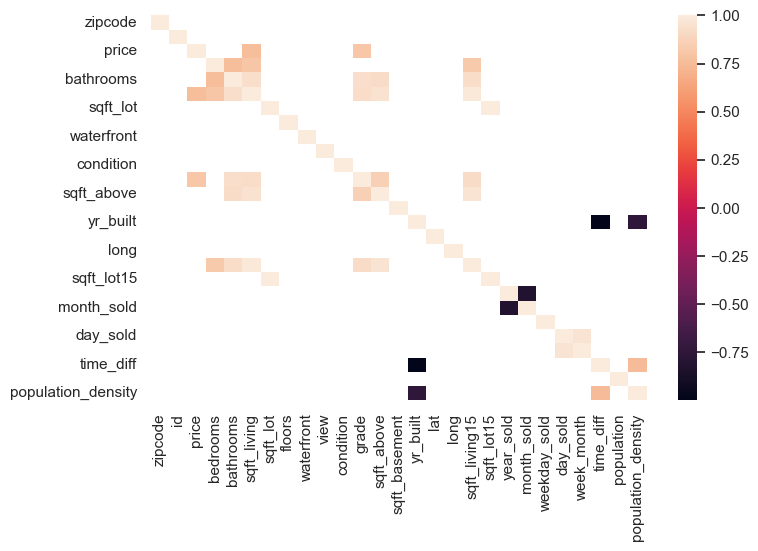

In [70]:

#sns.jointplot(ax=ax,data=df_zip,x='population',y='price', kind="kde")
sns.set(style="white")
g= sns.heatmap(df_zip.corr()[np.abs(df_zip.corr()) > 0.75])
cr = df_zip.corr()
cr = cr[np.abs(cr) > 0.75]

### 5.2 Group by year, month, weekday 
for Family Houses

In [72]:

df_s = df[df.bedrooms > 3][df.bedrooms < 7]
dm_weekday = df_s.groupby('weekday_sold').mean() - df_s.price.mean()
dm_month = df_s.groupby('month_sold').mean() - df_s.price.mean()
dm_day = df_s.groupby('day_sold').mean() - df_s.price.mean()
dm_week_month = df_s.groupby('week_month').mean() - df_s.price.mean()

# fig, [ax1,ax2] = plt.subplots(2,1)
# sns.set_style('darkgrid')
# sns.set_palette('Set2')
# plt.tight_layout()

# f1 = sns.barplot(data=dm_weekday,x=dm_weekday.index,y=dm_weekday.price,ax=ax1)
# f2 = sns.barplot(data=dm_month,x=dm_month.index,y=dm_month.price,ax=ax2)

# f1.set_ylim(- dm_weekday.price.max() * 1.1,dm_weekday.price.max() * 1.1)
# f2.set_ylim(- dm_month.price.abs().max() * 1.1,dm_month.price.abs().max() * 1.1)
# f2.set_ylabel('price in US$')


sns.set_style('whitegrid')
fig, [ax3,ax4] = plt.subplots(2,1)
f3 = sns.barplot(data=dm_month,x=dm_month.index,y=dm_month.price,ax=ax3, color = np.array([249, 191, 62])/255)
f4 = sns.barplot(data=dm_week_month,x=dm_week_month.index,y=dm_week_month.price,ax=ax4, color = np.array([249, 191, 62])/255)

f3.set_ylim(- dm_month.price.abs().max() * 1.1,dm_month.price.abs().max() * 1.1)
f4.set_ylim(- dm_week_month.price.abs().max() * 1.1,dm_week_month.price.abs().max() * 1.1)
[x.set_facecolor(np.array([np.array([154, 215, 210])/255])) for x in f3.patches if x.get_height() < 0 ]#
[x.set_facecolor(np.array([np.array([154, 215, 210])/255])) for x in f4.patches if x.get_height() < 0 ]
f3.set_yticks(np.arange(-60000,60000,20000))
f4.set_yticks(np.arange(-20000,21000,10000))
f4.set_ylim(-20000,20000)
f4.set_ylabel('$\Delta$ Price / USD',fontsize = 14)
f3.set_ylabel('$\Delta$ Price / USD',fontsize = 14)
f3.set_xlabel('Month of the Year',fontsize = 14)
f4.set_xlabel('Week of the Month',fontsize = 14)
plt.tight_layout()

f3.set_xticks(np.arange(0,12,1))
f3.set_xticklabels([x[:3] for x in list(calendar.month_name)[1:]],fontsize = 12)
f4.set_xticklabels([1,2,3,4], fontsize = 12)
f3.set_yticklabels(f3.get_yticklabels(), fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)



KeyError: 'weekday_sold'

### 5.3 Group by Population density
### Answering Hypthoses 1

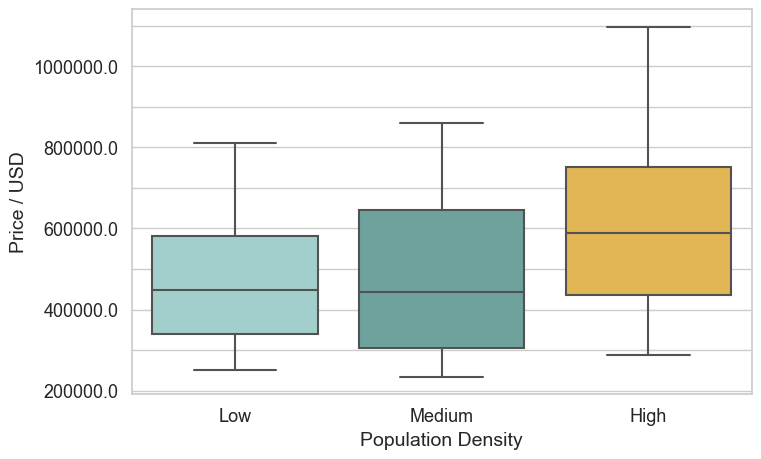

In [64]:
df_zip['q_pop_bins'], bins= pd.qcut(df_zip.population_density,3,retbins=True,labels=['Low','Medium','High'])
sns.set_style("whitegrid")
fig, ax = plt.subplots()
fsize = 14
my_pal = {"Medium": np.array([102, 170, 162])/255, "Low": np.array([154, 215, 210])/255, "High":np.array([249, 191, 62])/255} 
sns.boxplot(x ='q_pop_bins',y='price',data=df_zip,ax=ax,showfliers = False, palette=my_pal)
ax.set_xlabel('Population Density', fontsize = fsize)
ax.set_ylabel('Price / USD', fontsize = fsize)
plt.ticklabel_format(style='plain', axis='y')
plt.yticks(np.arange(2e5, 1.2e6, 1e5),labels=['' if x/1e5%2 else str(x) for x in np.arange(2e5, 1.2e6, 1e5)],fontsize = fsize-1)
plt.xticks(fontsize = fsize-1)
plt.gcf().dpi = 100
plt.gcf().set_size_inches(8,5)



## 6. Stackholder Recommendations

First of all we want so only select the houses with more than 3 bedrooms 

In [18]:
family_houses = df[df.bedrooms > 3][df.bedrooms < 7]


have a look where we can find most of these houses. Lets group by Zipcode

In [19]:
fam_house_zip = family_houses.groupby('zipcode').size().reset_index()
#Merge the number of houses into the zip_shape_df
zip_shape_fam_houses = pd.merge(zip_shape_df,fam_house_zip, left_on = 'ZIP', right_on = 'zipcode')
zip_shape_fam_houses = zip_shape_fam_houses.set_axis([*zip_shape_fam_houses.columns[:-1], 'Num_of_fam_houses'], axis=1, inplace=False).sort_values(by='Num_of_fam_houses',ascending=False)
zip_shape_fam_houses.head()


fam_house_zip = family_houses.groupby('zipcode').median().reset_index()
#Merge the number of houses into the zip_shape_df
zip_shape_fam_houses = pd.merge(zip_shape_fam_houses,fam_house_zip[['zipcode','sqft_living','sqft_lot','price']], left_on = 'ZIP', right_on = 'zipcode')
zip_shape_fam_houses = zip_shape_fam_houses.set_axis([*zip_shape_fam_houses.columns[:-1], 'Mean_price'], axis=1, inplace=False).sort_values(by='Mean_price',ascending=True)
zip_shape_fam_houses.drop(['ZIP', 'zipcode_x','zipcode_y'],axis = 1).head()

,OBJECTID,ZIPCODE,COUNTY,ZIP_TYPE,COUNTY_NAM,PREFERRED_,Shape_Leng,Shape_Area,geometry,population,population_density,Num_of_fam_houses,sqft_living,sqft_lot,Mean_price
53,2,98002,033,Standard,King County,AUBURN,105168.477,204445228.298,"POLYGON ((-122.22921 47.35375, -122.22915 47.3...",30815.000,4053.550,67,2120.000,7665.000,269950.000
52,94,98168,033,Standard,King County,SEATTLE,105513.044,258959463.097,"POLYGON ((-122.29151 47.51370, -122.29188 47.5...",30198.000,3295.070,71,1850.000,8500.000,273500.000
61,28,98032,033,Standard,King County,KENT,162578.138,480428912.045,"MULTIPOLYGON (((-122.24187 47.44122, -122.2411...",28778.000,1726.830,50,2190.000,8668.500,282963.500
42,100,98198,033,Standard,King County,SEATTLE,120954.751,212912872.253,"POLYGON ((-122.31455 47.42435, -122.31454 47.4...",33561.000,4488.330,92,2050.000,8959.000,294691.000
21,1,98001,033,Standard,King County,AUBURN,148134.771,526121353.974,"POLYGON ((-122.22992 47.35377, -122.22993 47.3...",25771.000,1408.910,150,2185.500,8027.000,295750.000


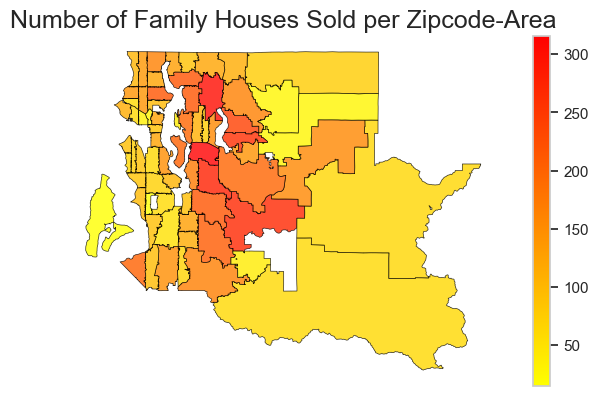

In [20]:
fig, ax1 = plt.subplots(1,1,figsize=(10, 4))
plt.tight_layout(pad=-10)
#king_county_shape.plot(ax=ax1, color='white', edgecolor='black', linewidth=1, alpha=0.2)
zip_shape_fam_houses.plot(ax=ax1, edgecolor='black', alpha=0.8, column=zip_shape_fam_houses.Num_of_fam_houses,cmap='autumn_r',categorical = False,linewidth=0.5,legend=True)
ax1.set_title('Number of Family Houses Sold per Zipcode-Area',fontsize = 18)
plt.axis('off')
fig.set_size_inches(5, 2)

### Also we can take a look a the Areas with the cheapest Family houses

,OBJECTID,ZIP,ZIPCODE,COUNTY,ZIP_TYPE,COUNTY_NAM,PREFERRED_,Shape_Leng,Shape_Area,geometry,population,population_density,zipcode_x,Num_of_fam_houses,zipcode_y,sqft_living,sqft_lot,Mean_price
53,2,98002,98002,033,Standard,King County,AUBURN,105168.477,204445228.298,"POLYGON ((-122.22921 47.35375, -122.22915 47.3...",30815.000,4053.550,98002,67,98002,2120.000,7665.000,269950.000
52,94,98168,98168,033,Standard,King County,SEATTLE,105513.044,258959463.097,"POLYGON ((-122.29151 47.51370, -122.29188 47.5...",30198.000,3295.070,98168,71,98168,1850.000,8500.000,273500.000
61,28,98032,98032,033,Standard,King County,KENT,162578.138,480428912.045,"MULTIPOLYGON (((-122.24187 47.44122, -122.2411...",28778.000,1726.830,98032,50,98032,2190.000,8668.500,282963.500


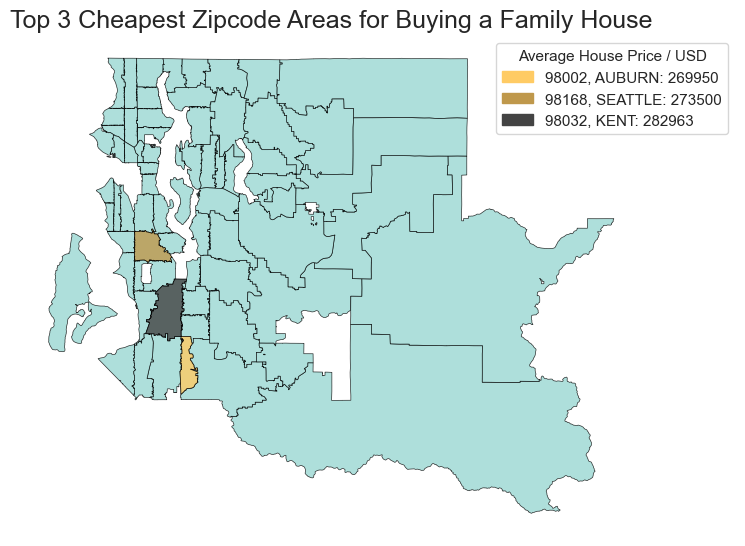

In [21]:
fig, [ax1,ax2] = plt.subplots(1,2,figsize=(4, 2),width_ratios=[10,1])
plt.tight_layout(pad = -10)
#king_county_shape.plot(ax=ax1, color='white', edgecolor='black', linewidth=1, alpha=0.2)
zip_shape_fam_houses.plot(ax=ax1, color = np.array([154, 215, 210])/255, edgecolor='black', alpha=0.8,linewidth=0.5)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [np.array([255, 203, 100])/255,0.75 * np.array([255, 203, 100])/255,np.array([67, 67, 67])/255])
p = (zip_shape_fam_houses.iloc[:3]
    .plot(ax=ax1, edgecolor='black', alpha=0.8, 
        column=zip_shape_fam_houses.iloc[:3].Mean_price.astype(int),
        cmap = cmap,categorical = True,linewidth=0.5)
    )

ax1.set_title('Top 3 Cheapest Zipcode Areas for Buying a Family House',fontsize = 18)
ax1.axis('off')
ax2.axis('off')
#p.get_legend().set_title('Population Density\npeople per sq. mi.')
#p.get_legend().set_title('Average House price / USD')

#list(p.get_legend_handles_labels().__str__)
#zip_shape_fam_houses.iloc[:3]
# create fake legend because it could not change the labels


a_patch = mpatches.Patch(color=np.array([255, 203, 100])/255, label=zip_shape_fam_houses['ZIPCODE'].iloc[0] + ', ' + zip_shape_fam_houses['PREFERRED_'].iloc[0] + ': ' + str(int(zip_shape_fam_houses['Mean_price'].iloc[0])))
b_patch = mpatches.Patch(color=0.75 * np.array([255, 203, 100])/255, label=zip_shape_fam_houses['ZIPCODE'].iloc[1] + ', ' + zip_shape_fam_houses['PREFERRED_'].iloc[1] + ': ' + str(int(zip_shape_fam_houses['Mean_price'].iloc[1])))
c_patch = mpatches.Patch(color=np.array([67, 67, 67])/255, label=zip_shape_fam_houses['ZIPCODE'].iloc[2] + ', ' + zip_shape_fam_houses['PREFERRED_'].iloc[2] + ': ' + str(int(zip_shape_fam_houses['Mean_price'].iloc[2])))
ax2.legend(handles=[a_patch, b_patch, c_patch],title = 'Average House Price / USD',fontsize = 11, title_fontsize = 11, loc = 'upper right')

#plt.gca().legend([1,2,3],['1','2','3'])

fig.set_size_inches(5, 2)

zip_shape_fam_houses.iloc[:3]

# Grade of family houses

grade
5    3.457
6   23.670
7   64.894
8    7.979
dtype: float64

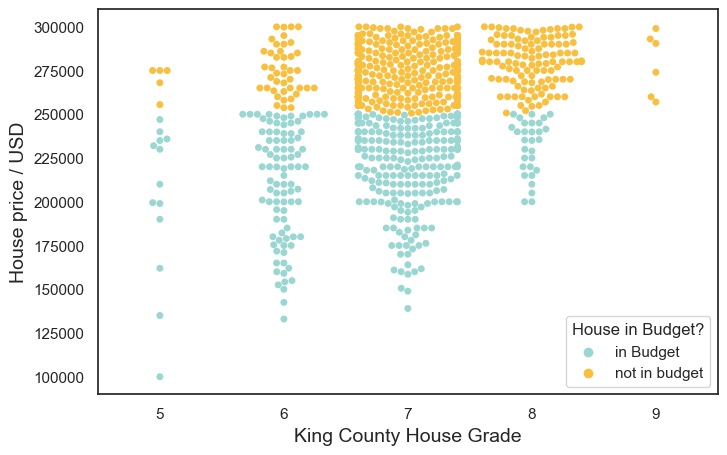

In [74]:
family_houses['grade_cat'] = np.where(family_houses.grade < 7, 'lower 7', 'higher 7')
family_houses['price_ok'] = np.where(family_houses.price <= 250e3, 'in Budget', 'not in budget')
#p = sns.boxplot(data=family_houses,y = 'price', x='grade_cat',showfliers=False)

p.set_ylim(0,9e5)

fam_cheap = family_houses[family_houses.price < 300e3]

sns.swarmplot(fam_cheap,y='price',x='grade', hue='price_ok', palette=[np.array([154, 215, 210])/255,np.array([249, 191, 62])/255])

plt.ylabel('House price / USD',fontsize = 14)
plt.legend(title='House in Budget?')
plt.xlabel('King County House Grade', fontsize = 14)
plt.gcf().set_size_inches(8,5)
fam_ch_grade = fam_cheap[fam_cheap.price_ok == 'in Budget'].groupby(['grade']).size()
fam_ch_grade = 100 * fam_ch_grade / fam_ch_grade.sum()
fam_ch_grade
